# Task 1: Training a 3-layer CNN to be fooled

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from PIL import Image
from pathlib import Path

# setting up training device? checking if GPU is available?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"Using device: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using CPU


### 3 layer CNN Arch


In [2]:
conv1_features = 8
conv2_features = 16

class ThreeLayerCNN(nn.Module): # objects map image tensors to logits (confidence scores for predicted digit)
    def __init__(self):
        super(ThreeLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, conv1_features, kernel_size=5, padding="same") # (input channels, output channels ie kernels applied, .., ..); padding keeps spatial size the same
        self.relu1 = nn.ReLU() # non-linear activation function - ReLU(a) = max(a,0);
        self.pool1 = nn.MaxPool2d(2) # downsampling 28x28 -> 14x14
        self.conv2 = nn.Conv2d(conv1_features, conv2_features, kernel_size=5, padding="same") # another conv, 4 channels from prev layer, 8 produced here
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2) # 14x14->7x7

        # 3 fully-connected layers (MLP head)
        self.fc1 = nn.Linear(conv2_features * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu_fc = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # flatten to (N, conv2_features*7*7)
        x = self.relu_fc(self.fc1(x))
        x = self.relu_fc(self.fc2(x))
        x = self.fc3(x)  # logits
        return x
model = ThreeLayerCNN()

### Load and Pre-process data

In [3]:
BASE_TRANSFORM = transforms.ToTensor() # HWC -> CWH, scaling from 0-255 to 0-1

DATA_ROOT = Path("../task0/outputs/colored-mnist")

# loads up csv into pandas data frame
def load_meta(split: str) -> pd.DataFrame:
    path = DATA_ROOT / split / "labels.csv"
    if not path.exists():
        raise FileNotFoundError(f"{path} not found. Run generation first.")
    return pd.read_csv(path)

# loads image from disk, with normalization cuz it calls BASE_TRANSFORM
def _load_rgb(split: str, filename: str) -> torch.Tensor:
    path = DATA_ROOT / split / "images" / filename
    return BASE_TRANSFORM(Image.open(path).convert("RGB"))


class ColoredMNISTDataset(Dataset):
    def __init__(self, split: str, subset_indices=None):
        assert split in {"train", "test"}
        self.split = split
        self.meta = load_meta(split) # pd data frame for this split

        if subset_indices is not None:
            self.meta = self.meta.iloc[subset_indices].reset_index(drop=True)
        # talking only a subset of the data for train/val split, and ensuring 0 indexing of this subset

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        img = _load_rgb(self.split, row.filename)  # (3, 28, 28)
        label = int(row.label)
        return img, label # label is the digit inside the image!


# Use the full provided train/test splits (no train/val split)
train_dataset = ColoredMNISTDataset("train")
test_dataset = ColoredMNISTDataset("test")

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 60000
Test samples: 10000


### Training

In [4]:
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0)
# params - all learnable parameters of the model
# lr = step size, typically 0.1,0.01,0.001
# momentum accumulates past gradients to smoothen updates
criterion = nn.CrossEntropyLoss()
model = model.to(device)

def evaluate(loader, name):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader: # load one batch at a time
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"{name} Accuracy: {acc:.2f}%")
    return acc


epochs = 7
print(f"Training for {epochs} epochs...")

for epoch in range(epochs):
    model.train() # enables training behavior like dropout, batchnorm updates
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # zero the parameter gradients, pytorch accumulates gradients by default
        outputs = model(images) # produces logits
        loss = criterion(outputs, labels) # compute loss
        loss.backward() # gradients of loss w.r.t. all parameters
        optimizer.step() # update parameters using SGD + momentum
        running_loss += loss.item()

    # Evaluate at end of epoch
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f}")
    evaluate(train_loader, "Train")
    evaluate(test_loader, "Test")
    print("-" * 30)

print("Training Complete.")
print("Final Evaluation:")
evaluate(train_loader, "Train")
evaluate(test_loader, "Test")

Training for 7 epochs...


/home/bonda/Documents/precog_application/cv-task/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch [1/7] - Loss: 2.3034
Train Accuracy: 10.36%
Test Accuracy: 9.80%
------------------------------
Epoch [2/7] - Loss: 2.2991
Train Accuracy: 23.48%
Test Accuracy: 1.05%
------------------------------
Epoch [3/7] - Loss: 2.2880
Train Accuracy: 26.35%
Test Accuracy: 11.35%
------------------------------
Epoch [4/7] - Loss: 2.1599
Train Accuracy: 26.75%
Test Accuracy: 11.52%
------------------------------
Epoch [5/7] - Loss: 1.4869
Train Accuracy: 61.92%
Test Accuracy: 5.15%
------------------------------
Epoch [6/7] - Loss: 0.9662
Train Accuracy: 92.25%
Test Accuracy: 0.00%
------------------------------
Epoch [7/7] - Loss: 0.4762
Train Accuracy: 93.31%
Test Accuracy: 0.44%
------------------------------
Training Complete.
Final Evaluation:
Train Accuracy: 93.31%
Test Accuracy: 0.44%


0.44

In [7]:
def save_model_weights(name: str, output_dir: str = "saved_models") -> str:
    """Save model weights to disk.

    Args:
        name: Filename stem or full filename (e.g., "cnn_v1" or "cnn_v1.pth").
        output_dir: Directory to save weights in.

    Returns:
        The full path to the saved weights file.
    """
    if not name:
        raise ValueError("name must be a non-empty string")

    filename = name if name.endswith(".pth") else f"{name}.pth"
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    full_path = output_path / filename
    torch.save(model.state_dict(), full_path)
    print(f"Saved weights to: {full_path}")
    return str(full_path)

# Example usage:
# save_model_weights("cnn_weights_v1")

save_model_weights("cnn_weights_feb1_GODLYPULL")

Saved weights to: saved_models/cnn_weights_feb1_GODLYPULL.pth


'saved_models/cnn_weights_feb1_GODLYPULL.pth'

Easy (train) accuracy: 93.30% (60000 samples)
Hard (test) accuracy:  0.44% (10000 samples)


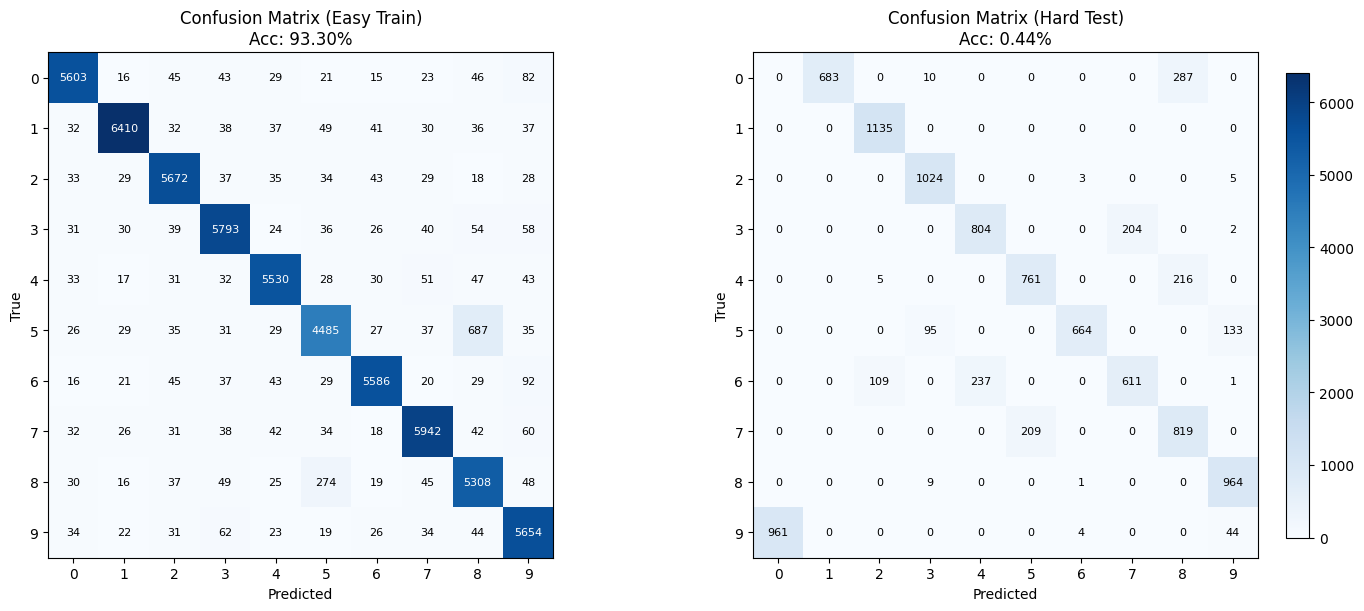

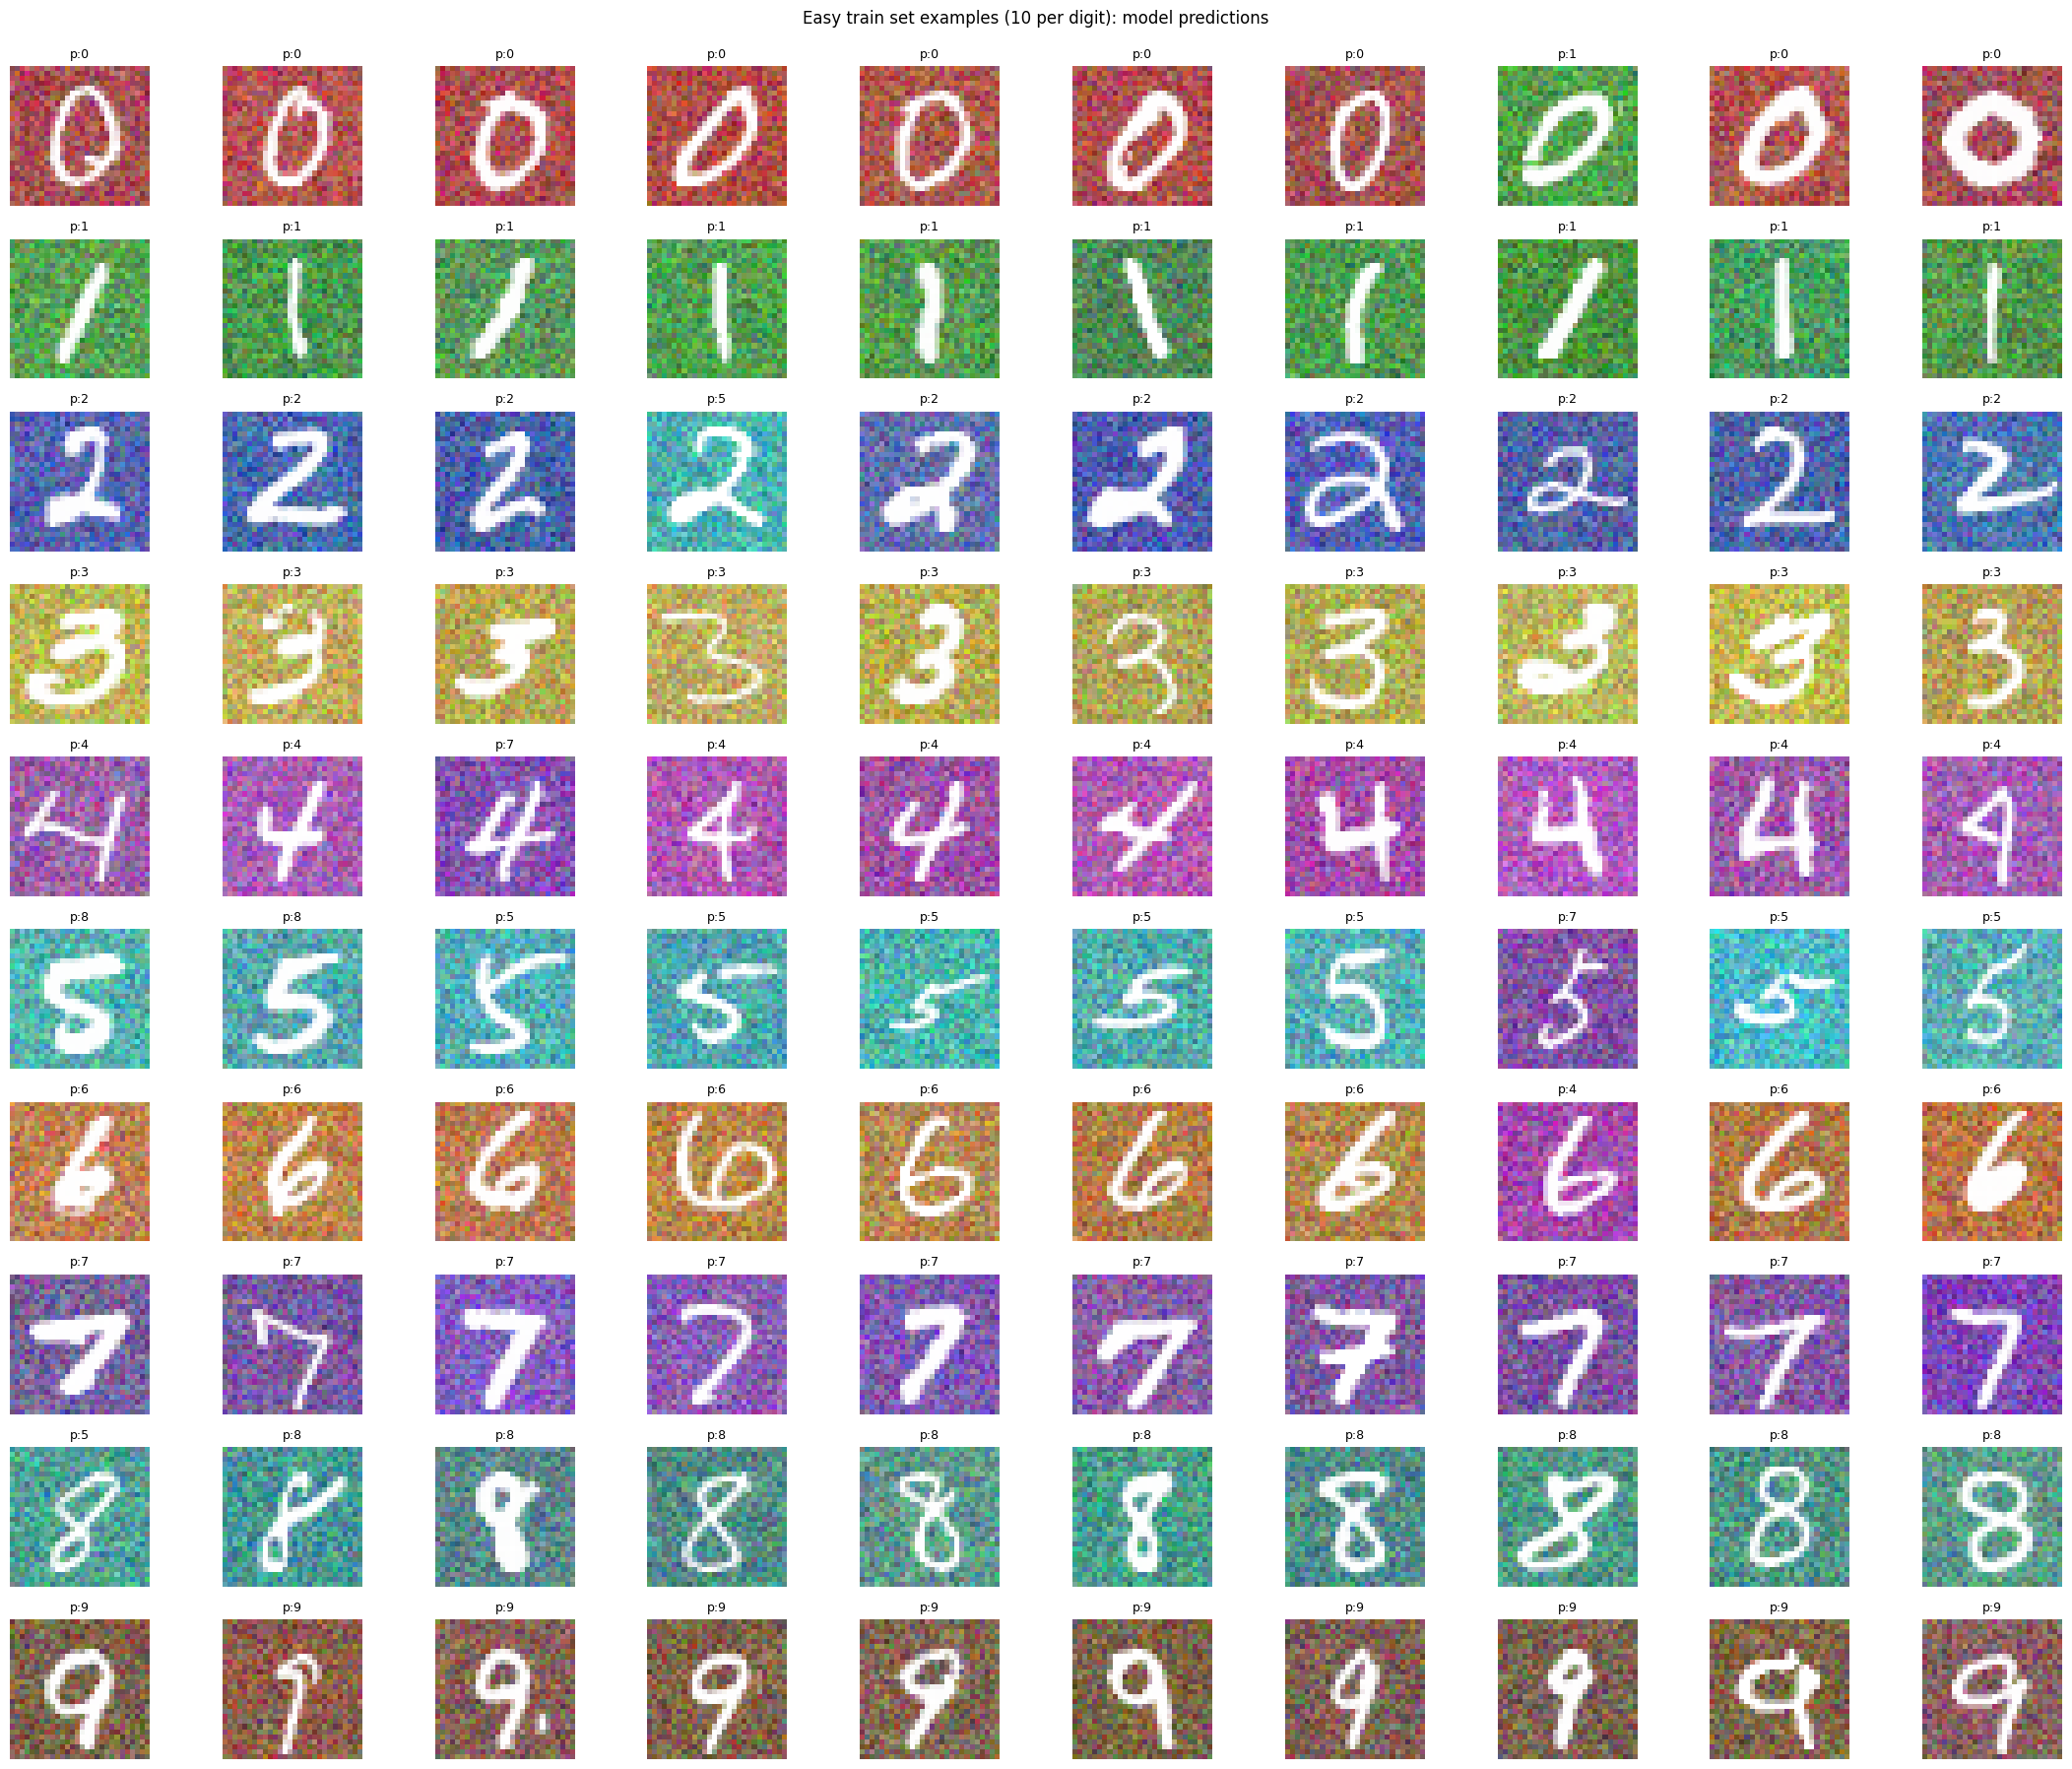

Easy train set examples (10 per digit): model predictions | digit 0 preds: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Easy train set examples (10 per digit): model predictions | digit 1 preds: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Easy train set examples (10 per digit): model predictions | digit 2 preds: [2, 2, 2, 5, 2, 2, 2, 2, 2, 2]
Easy train set examples (10 per digit): model predictions | digit 3 preds: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Easy train set examples (10 per digit): model predictions | digit 4 preds: [4, 4, 7, 4, 4, 4, 4, 4, 4, 4]
Easy train set examples (10 per digit): model predictions | digit 5 preds: [8, 8, 5, 5, 5, 5, 5, 7, 5, 5]
Easy train set examples (10 per digit): model predictions | digit 6 preds: [6, 6, 6, 6, 6, 6, 6, 4, 6, 6]
Easy train set examples (10 per digit): model predictions | digit 7 preds: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Easy train set examples (10 per digit): model predictions | digit 8 preds: [5, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Easy train set examples (10 per digit): model 

/home/bonda/Documents/precog_application/cv-task/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


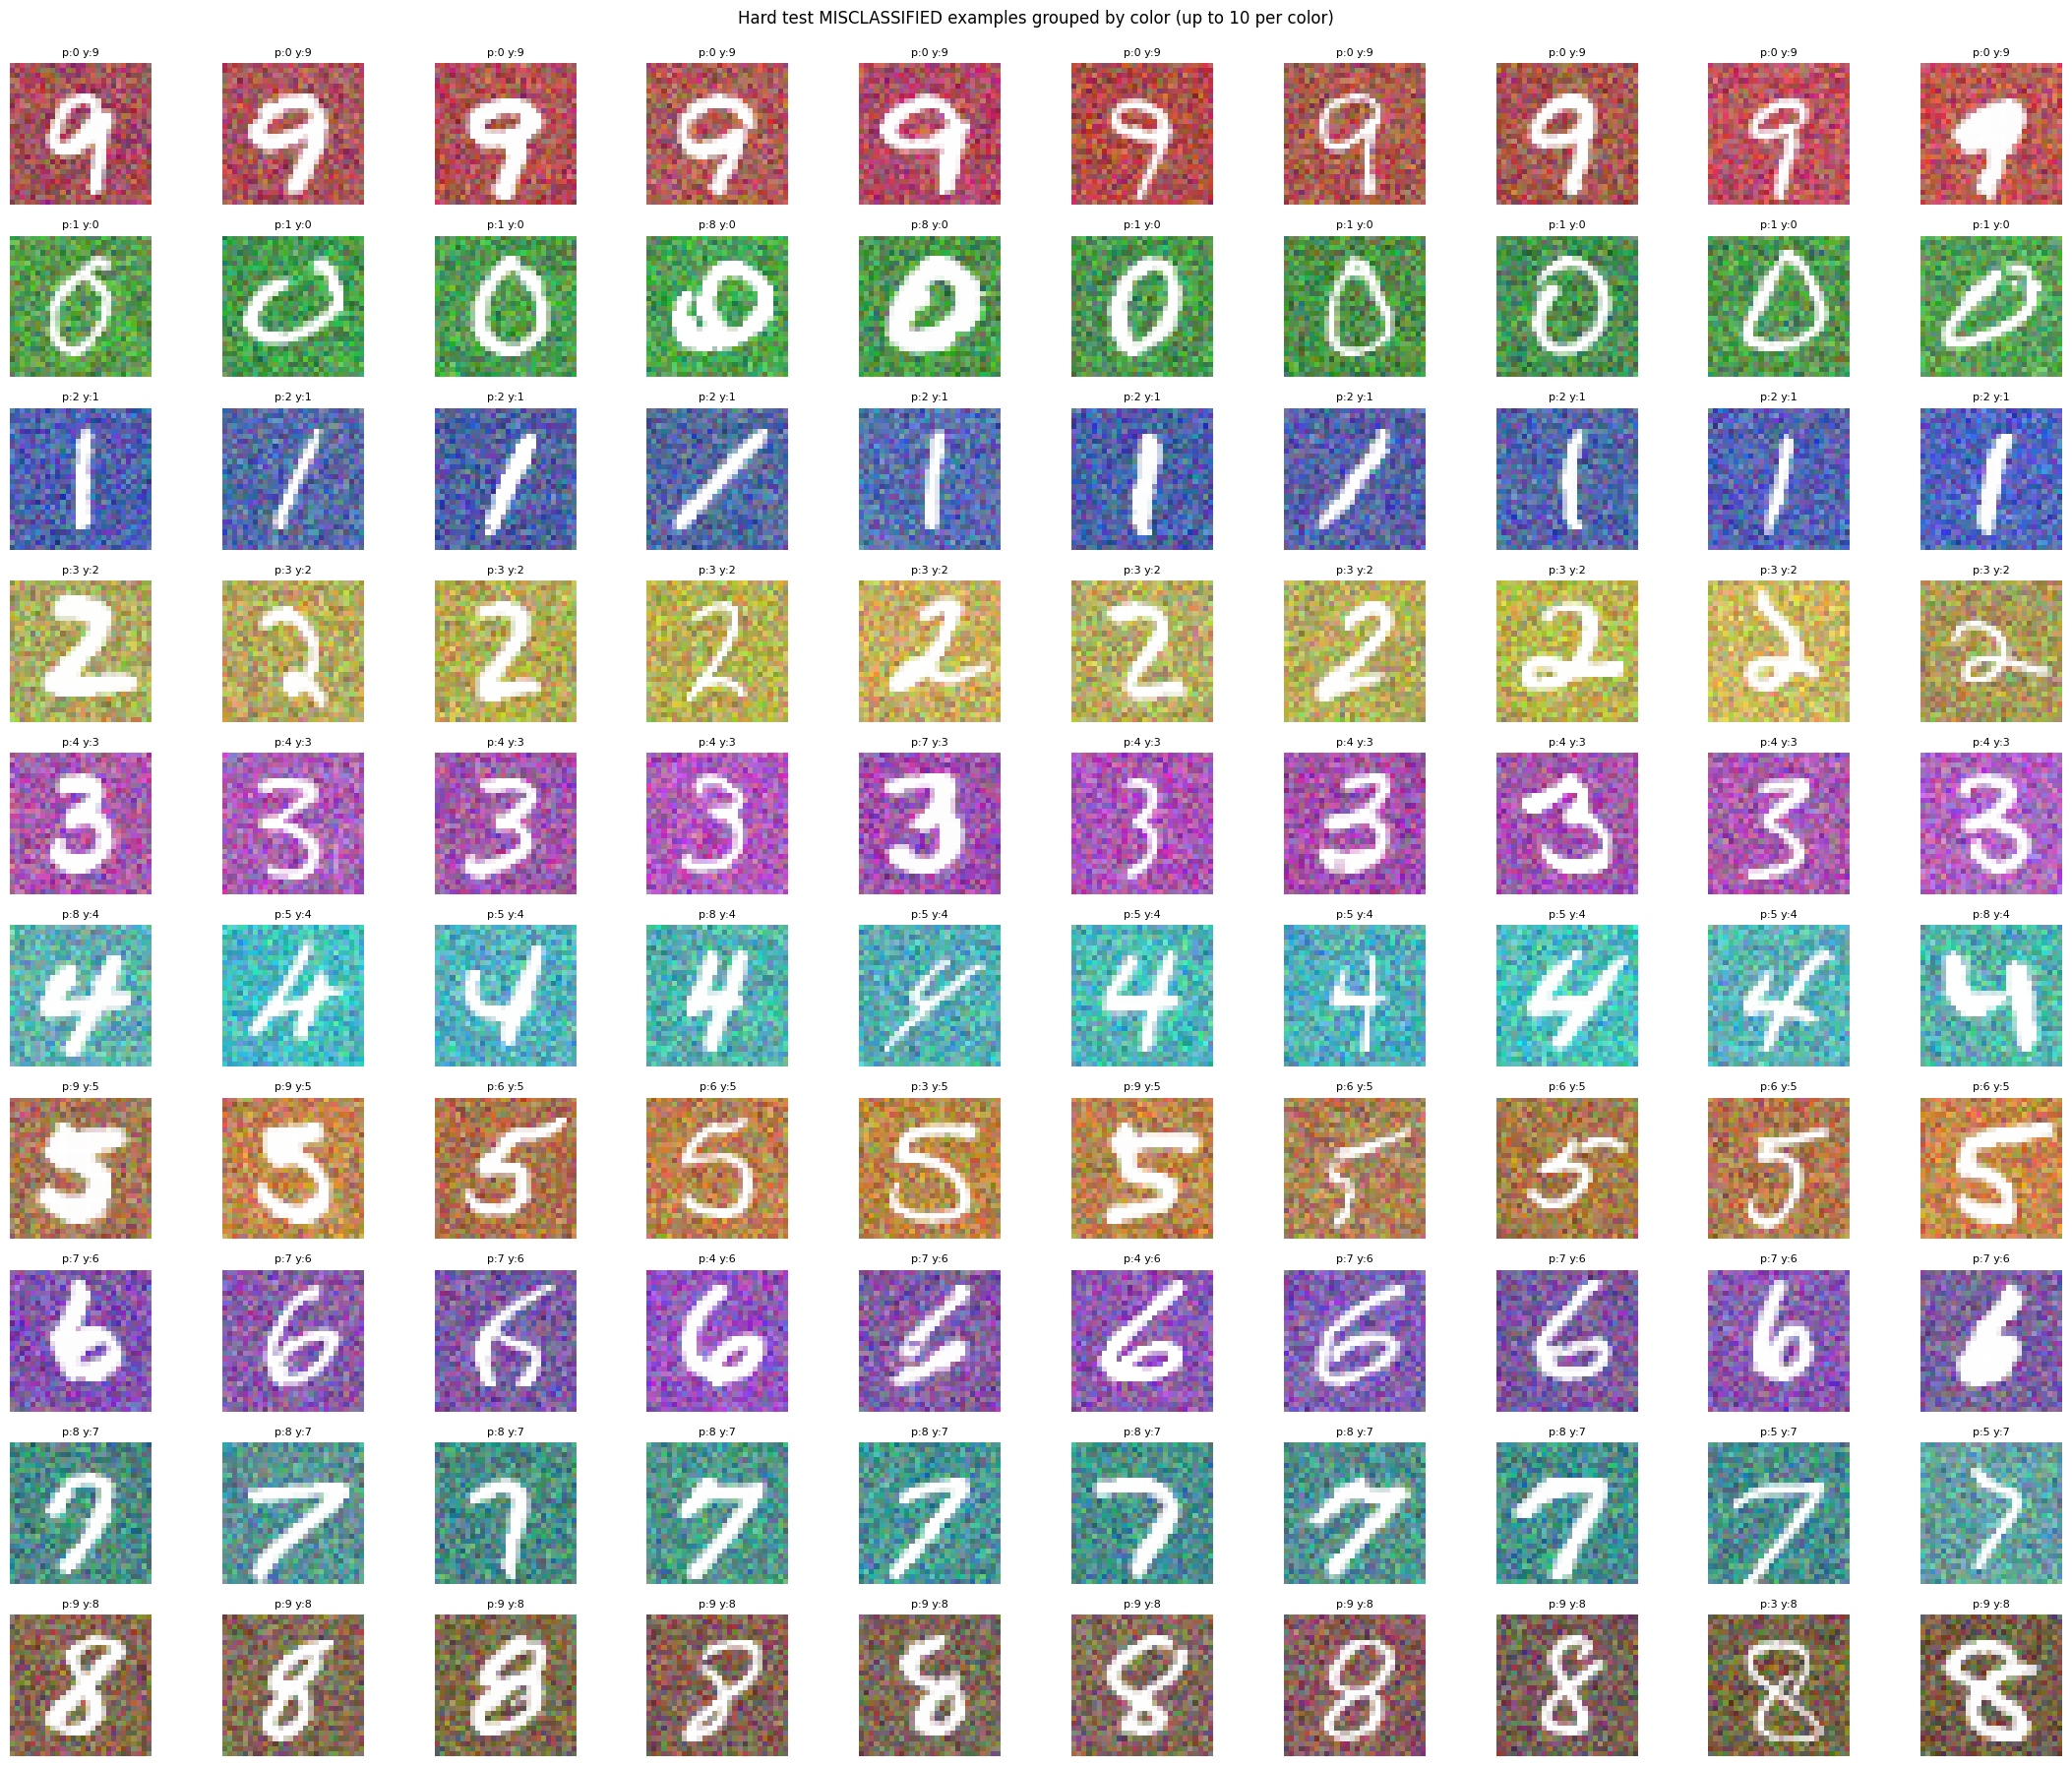

Hard test MISCLASSIFIED examples grouped by color (up to 10 per color) | color 0 (red) misclassified preds: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Hard test MISCLASSIFIED examples grouped by color (up to 10 per color) | color 1 (green) misclassified preds: [1, 1, 1, 8, 8, 1, 1, 1, 1, 1]
Hard test MISCLASSIFIED examples grouped by color (up to 10 per color) | color 2 (blue) misclassified preds: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Hard test MISCLASSIFIED examples grouped by color (up to 10 per color) | color 3 (yellow) misclassified preds: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Hard test MISCLASSIFIED examples grouped by color (up to 10 per color) | color 4 (magenta) misclassified preds: [4, 4, 4, 4, 7, 4, 4, 4, 4, 4]
Hard test MISCLASSIFIED examples grouped by color (up to 10 per color) | color 5 (cyan) misclassified preds: [8, 5, 5, 8, 5, 5, 5, 5, 5, 8]
Hard test MISCLASSIFIED examples grouped by color (up to 10 per color) | color 6 (orange) misclassified preds: [9, 9, 6, 6, 3, 9, 6, 6, 6, 6]
Hard test MIS

In [ ]:
# --- Evaluation on EASY (biased train) and HARD (debiased test) sets ---
# In this project setup:
# - train_dataset/train_loader: easy (biased) set
# - test_dataset/test_loader: hard (debiased) set
#
# Note: confusion matrices below are computed over the FULL datasets (all batches in each loader).

import numpy as np

@torch.no_grad()
def get_predictions_and_labels(loader: DataLoader):
    model.eval()
    preds_all = []
    labels_all = []
    for images, labels in loader:
        images = images.to(device)
        logits = model(images)
        preds = logits.argmax(dim=1).cpu()
        preds_all.append(preds)
        labels_all.append(labels.cpu())
    return torch.cat(preds_all), torch.cat(labels_all)

def confusion_matrix_10(labels: torch.Tensor, preds: torch.Tensor) -> torch.Tensor:
    cm = torch.zeros((10, 10), dtype=torch.int64)
    for t, p in zip(labels, preds):
        cm[int(t), int(p)] += 1
    return cm

def plot_confusion_matrices_side_by_side(cm_left: torch.Tensor, cm_right: torch.Tensor, title_left: str, title_right: str):
    """Plot two 10x10 confusion matrices side-by-side with a non-overlapping shared colorbar."""
    vmax = int(torch.max(cm_left.max(), cm_right.max()).item())
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

    im_left = axes[0].imshow(cm_left.numpy(), cmap="Blues", vmin=0, vmax=vmax)
    im_right = axes[1].imshow(cm_right.numpy(), cmap="Blues", vmin=0, vmax=vmax)

    for ax, cm, title in [(axes[0], cm_left, title_left), (axes[1], cm_right, title_right)]:
        ax.set_title(title)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_xticks(range(10))
        ax.set_yticks(range(10))
        # annotate cells
        for i in range(10):
            for j in range(10):
                val = int(cm[i, j])
                color = "white" if vmax and val > vmax * 0.5 else "black"
                ax.text(j, i, str(val), ha="center", va="center", fontsize=8, color=color)

    # Shared colorbar (avoids overlap by letting constrained_layout manage spacing)
    fig.colorbar(im_right, ax=axes.ravel().tolist(), shrink=0.92, pad=0.02)
    plt.show()

@torch.no_grad()
def show_examples_with_predictions(dataset: Dataset, *, title: str, examples_per_digit: int, seed: int = 0):
    """Show a (10 x examples_per_digit) grid: each row is the true digit and each tile shows the model prediction."""
    if not hasattr(dataset, "meta"):
        raise ValueError("Dataset must have a .meta DataFrame to sample by label")

    meta = dataset.meta.copy()
    meta["label"] = meta["label"].astype(int)

    rng = np.random.default_rng(seed)
    chosen_indices = []
    for d in range(10):
        idxs = meta.index[meta["label"] == d].to_numpy()
        if len(idxs) == 0:
            print(f"Warning: no examples for digit {d}")
            continue
        if len(idxs) < examples_per_digit:
            print(f"Warning: only found {len(idxs)} examples for digit {d}")
            chosen = idxs
        else:
            chosen = rng.choice(idxs, size=examples_per_digit, replace=False)
        chosen_indices.extend(chosen.tolist())

    # Load selected images/labels
    imgs = []
    labels_true = []
    for idx in chosen_indices:
        img, y = dataset[int(idx)]
        imgs.append(img)
        labels_true.append(int(y))

    # Predict in one batch
    batch = torch.stack(imgs, dim=0).to(device)
    logits = model(batch)
    preds = logits.argmax(dim=1).cpu().numpy().tolist()

    fig, axes = plt.subplots(10, examples_per_digit, figsize=(2.2 * examples_per_digit, 18))
    fig.suptitle(title, y=0.995)

    k = 0
    per_digit_preds = {d: [] for d in range(10)}
    for row_digit in range(10):
        for col in range(examples_per_digit):
            ax = axes[row_digit, col] if examples_per_digit > 1 else axes[row_digit]
            img = imgs[k]
            y_pred = int(preds[k])
            per_digit_preds[row_digit].append(y_pred)
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.set_title(f"p:{y_pred}", fontsize=9)
            ax.axis("off")
            if col == 0:
                ax.set_ylabel(f"true {row_digit}", rotation=0, labelpad=28, fontsize=10, va="center")
            k += 1

    plt.tight_layout()
    plt.show()

    # Quick text summary
    for d in range(10):
        if d in per_digit_preds:
            print(f"{title} | digit {d} preds: {per_digit_preds[d]}")

@torch.no_grad()
def show_test_examples_grouped_by_color(dataset: Dataset, *, title: str, examples_per_color: int = 10, seed: int = 0):
    """Show a (10 x examples_per_color) grid for the TEST set grouped by `color_digit` (i.e., color category).
    Only MISCLASSIFIED samples are shown (incorrect predictions).
    """
    if not hasattr(dataset, "meta"):
        raise ValueError("Dataset must have a .meta DataFrame")
    if "color_digit" not in dataset.meta.columns:
        raise ValueError("dataset.meta must include a 'color_digit' column")

    # Mapping from task0/custom-mnist.ipynb palette comments
    # 0 red, 1 green, 2 blue, 3 yellow, 4 magenta, 5 cyan, 6 orange, 7 purple, 8 teal, 9 brown
    COLOR_NAMES = {
        0: "red",
        1: "green",
        2: "blue",
        3: "yellow",
        4: "magenta",
        5: "cyan",
        6: "orange",
        7: "purple",
        8: "teal",
        9: "brown",
    }

    # Get predictions aligned with dataset index order (shuffle=False)
    ordered_loader = DataLoader(
        dataset,
        batch_size=256,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    preds_all, labels_all = get_predictions_and_labels(ordered_loader)
    preds_np = preds_all.numpy()
    labels_np = labels_all.numpy()
    incorrect = preds_np != labels_np

    meta = dataset.meta.copy()
    meta["label"] = meta["label"].astype(int)
    meta["color_digit"] = meta["color_digit"].astype(int)
    color_np = meta["color_digit"].to_numpy()

    rng = np.random.default_rng(seed)
    per_color_indices: dict[int, list[int]] = {}
    for c in range(10):
        idxs = np.where((color_np == c) & incorrect)[0]
        if len(idxs) == 0:
            per_color_indices[c] = []
            print(f"Warning: no MISCLASSIFIED examples for color_digit={c} ({COLOR_NAMES.get(c, str(c))})")
            continue
        chosen = rng.choice(idxs, size=min(examples_per_color, len(idxs)), replace=False)
        per_color_indices[c] = chosen.astype(int).tolist()
        if len(per_color_indices[c]) < examples_per_color:
            print(
                f"Warning: only found {len(per_color_indices[c])} MISCLASSIFIED examples for "
                f"color_digit={c} ({COLOR_NAMES.get(c, str(c))})"
            )

    fig, axes = plt.subplots(10, examples_per_color, figsize=(2.2 * examples_per_color, 18))
    fig.suptitle(title, y=0.995)

    per_color_preds = {c: [] for c in range(10)}
    for row_color in range(10):
        row_idxs = per_color_indices.get(row_color, [])
        for col in range(examples_per_color):
            ax = axes[row_color, col] if examples_per_color > 1 else axes[row_color]
            if col == 0:
                cname = COLOR_NAMES.get(row_color, str(row_color))
                ax.set_ylabel(f"{cname}\n(c{row_color})", rotation=0, labelpad=34, fontsize=10, va="center")

            if col >= len(row_idxs):
                ax.axis("off")
                continue

            idx = int(row_idxs[col])
            img, _ = dataset[idx]
            y_true = int(labels_np[idx])
            y_pred = int(preds_np[idx])
            per_color_preds[row_color].append(y_pred)

            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.set_title(f"p:{y_pred} y:{y_true}", fontsize=8)
            ax.axis("off")

    plt.tight_layout()
    plt.show()

    for c in range(10):
        cname = COLOR_NAMES.get(c, str(c))
        print(f"{title} | color {c} ({cname}) misclassified preds: {per_color_preds[c]}")

# Compute predictions/labels over FULL datasets via the loaders
train_preds, train_labels = get_predictions_and_labels(train_loader)
test_preds, test_labels = get_predictions_and_labels(test_loader)

train_acc = (train_preds == train_labels).float().mean().item() * 100.0
test_acc = (test_preds == test_labels).float().mean().item() * 100.0
print(f"Easy (train) accuracy: {train_acc:.2f}% ({len(train_labels)} samples)")
print(f"Hard (test) accuracy:  {test_acc:.2f}% ({len(test_labels)} samples)")

cm_train = confusion_matrix_10(train_labels, train_preds)
cm_test = confusion_matrix_10(test_labels, test_preds)

plot_confusion_matrices_side_by_side(
    cm_train,
    cm_test,
    title_left=f"Confusion Matrix (Easy Train)\nAcc: {train_acc:.2f}%",
    title_right=f"Confusion Matrix (Hard Test)\nAcc: {test_acc:.2f}%",
)

# --- Visualize images + predictions (Easy Train) ---
show_examples_with_predictions(
    train_dataset,
    title="Easy train set examples (10 per digit): model predictions",
    examples_per_digit=10,
    seed=0,
 )

# --- Visualize TEST images by COLOR (misclassified only) ---
show_test_examples_grouped_by_color(
    test_dataset,
    title="Hard test MISCLASSIFIED examples grouped by color (up to 10 per color)",
    examples_per_color=10,
    seed=1,
 )